In [27]:
import torch
import torch.nn as nn
import math
#多头自注意力（Multi-head Self-Attention）
class MultiHeadSelfAttention(nn.Module):
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model 必须能被 num_heads 整除"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # 线性变换：Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 输出投影
        self.W_o = nn.Linear(d_model, d_model)

        # 缩放因子：sqrt(d_k)
        self.scale = math.sqrt(self.head_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        # 线性变换并拆分头
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (B, H, L, D)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # 缩放点积注意力
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (B, H, L, L)

        # 应用掩码（防止未来 token 被看到）
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Softmax 得到注意力权重
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # 加权求和
        context = torch.matmul(attn, V)  # (B, H, L, D)

        # 合并多头
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)

        # 输出投影
        output = self.W_o(context)
        return output

In [28]:
#逐位置前馈网络（Position-wise Feed-Forward Network, FFN）
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        x = self.fc1(x)           # (B, L, d_ff)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)           # (B, L, d_model)
        return x

In [29]:
#残差连接 + 层归一化（Residual Connection + Layer Normalization）
class AddNorm(nn.Module):
   
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_output):
        return self.norm(x + self.dropout(sublayer_output))

In [30]:
#位置编码（Positional Encoding，可以是正弦型或可学习型）
#正弦型
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (L, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维

        pe = pe.unsqueeze(0)  # (1, L, D)
        self.register_buffer('pe', pe)  # 注册为 buffer，不参与梯度更新

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
#学习型
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        return x + self.pe(positions)

In [31]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)

    def forward(self, x, mask):
        # 自注意力 + 残差 + 归一化
        attn_out = self.attn(x, mask)
        x = self.add_norm1(x, attn_out)

        # 前馈网络 + 残差 + 归一化
        ffn_out = self.ffn(x)
        x = self.add_norm2(x, ffn_out)

        return x

In [32]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=4, d_ff=1024, 
                 max_len=128, pos_encoding='sinusoidal', dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        
        if pos_encoding == 'sinusoidal':
            self.pos_emb = PositionalEncoding(d_model, max_len)
        elif pos_encoding == 'learnable':
            self.pos_emb = LearnablePositionalEncoding(d_model, max_len)
        else:
            raise ValueError("pos_encoding must be 'sinusoidal' or 'learnable'")
        
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.token_emb.weight  # Weight tying
        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, input_ids, attention_mask=None):
        x = self.token_emb(input_ids)
        x = self.pos_emb(x)
        x = self.dropout(x)

        # 自回归掩码
        L = input_ids.size(1)
        if attention_mask is None:
            attention_mask = torch.tril(torch.ones(L, L, device=input_ids.device)).bool()

        for layer in self.layers:
            x = layer(x, attention_mask)

        x = self.final_norm(x)
        logits = self.lm_head(x)
        return logits

In [7]:
!pip install transformers datasets torch matplotlib tqdm

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from datasets import load_from_disk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 确保导入成功
print("✅ 所有库导入成功！")

✅ 所有库导入成功！


In [34]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/root/autodl-tmp/data/gpt2_local")
tokenizer.pad_token = tokenizer.eos_token
print("✅ 本地加载成功！")

✅ 本地加载成功！


In [35]:
# 加载本地数据集
dataset = load_from_disk("/root/data/wikitext-103-raw-v1")

In [36]:
# 小规模训练（调试用）
train_data = dataset["train"].select(range(10000))
val_data = dataset["validation"].select(range(1000))

def collate_fn(batch):
    texts = [item["text"] for item in batch]
    encoded = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    input_ids = encoded["input_ids"]
    labels = input_ids.clone()
    labels[:, :-1] = input_ids[:, 1:]  # Shift right
    labels[:, -1] = -100  # Ignore last token loss
    return {"input_ids": input_ids, "labels": labels}

train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

def train_with_accuracy(model, train_loader, val_loader, epochs=10, lr=3e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    # 存储指标
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # --- 训练阶段 ---
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        num_samples = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)  # shape: (B, L)

            logits = model(input_ids)  # shape: (B, L, V)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # 计算准确率 (只计算非 -100 的 token)
            preds = logits.argmax(dim=-1)  # (B, L)
            masked_labels = labels[labels != -100]
            masked_preds = preds[labels != -100]
            if len(masked_labels) > 0:
                acc = (masked_preds == masked_labels).float().mean().item()
                epoch_acc += acc * len(masked_labels)
                num_samples += len(masked_labels)

        avg_train_loss = epoch_loss / len(train_loader)
        avg_train_acc = epoch_acc / num_samples if num_samples > 0 else 0

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        # --- 验证阶段 ---
        model.eval()
        val_loss = 0
        val_acc = 0
        val_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids)
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=-100)
                val_loss += loss.item()

                preds = logits.argmax(dim=-1)
                masked_labels = labels[labels != -100]
                masked_preds = preds[labels != -100]
                if len(masked_labels) > 0:
                    acc = (masked_preds == masked_labels).float().mean().item()
                    val_acc += acc * len(masked_labels)
                    val_samples += len(masked_labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_samples if val_samples > 0 else 0

        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        print(f"Epoch {epoch+1}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        scheduler.step()

    return train_losses, val_losses, train_accs, val_accs

In [38]:
# 实验1：正弦位置编码
model_sinusoidal = TransformerLM(
    vocab_size=tokenizer.vocab_size,
    d_model=256,
    num_heads=8,
    num_layers=4,
    d_ff=1024,
    pos_encoding='sinusoidal'
)

print("🚀 Training with Sinusoidal Positional Encoding...")
train_losses_s, val_losses_s, train_accs_s, val_accs_s = train_with_accuracy(
    model_sinusoidal, train_loader, val_loader, epochs=10
)

# 实验2：可学习位置编码
model_learnable = TransformerLM(
    vocab_size=tokenizer.vocab_size,
    d_model=256,
    num_heads=8,
    num_layers=4,
    d_ff=1024,
    pos_encoding='learnable'
)

print("🚀 Training with Learnable Positional Encoding...")
train_losses_l, val_losses_l, train_accs_l, val_accs_l = train_with_accuracy(
    model_learnable, train_loader, val_loader, epochs=10
)

🚀 Training with Sinusoidal Positional Encoding...


Epoch 1 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 1, Train Loss: 10.1255, Train Acc: 0.6475, Val Loss: 5.2827, Val Acc: 0.6926


Epoch 2 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.43it/s]


Epoch 2, Train Loss: 4.8964, Train Acc: 0.6663, Val Loss: 3.5856, Val Acc: 0.6979


Epoch 3 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.40it/s]


Epoch 3, Train Loss: 3.8392, Train Acc: 0.6728, Val Loss: 3.2452, Val Acc: 0.7011


Epoch 4 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.37it/s]


Epoch 4, Train Loss: 3.4952, Train Acc: 0.6762, Val Loss: 3.0443, Val Acc: 0.7065


Epoch 5 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.36it/s]


Epoch 5, Train Loss: 3.2962, Train Acc: 0.6784, Val Loss: 2.9620, Val Acc: 0.7064


Epoch 6 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.41it/s]


Epoch 6, Train Loss: 3.2008, Train Acc: 0.6790, Val Loss: 2.8907, Val Acc: 0.7054


Epoch 7 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.31it/s]


Epoch 7, Train Loss: 3.1231, Train Acc: 0.6800, Val Loss: 2.8560, Val Acc: 0.7066


Epoch 8 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.27it/s]


Epoch 8, Train Loss: 3.0821, Train Acc: 0.6805, Val Loss: 2.8324, Val Acc: 0.7080


Epoch 9 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.21it/s]


Epoch 9, Train Loss: 3.0472, Train Acc: 0.6808, Val Loss: 2.8191, Val Acc: 0.7074


Epoch 10 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.22it/s]


Epoch 10, Train Loss: 3.0279, Train Acc: 0.6812, Val Loss: 2.8012, Val Acc: 0.7084
🚀 Training with Learnable Positional Encoding...


Epoch 1 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.23it/s]


Epoch 1, Train Loss: 9.7725, Train Acc: 0.6471, Val Loss: 5.1709, Val Acc: 0.6949


Epoch 2 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.15it/s]


Epoch 2, Train Loss: 4.8780, Train Acc: 0.6660, Val Loss: 3.6495, Val Acc: 0.6953


Epoch 3 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.09it/s]


Epoch 3, Train Loss: 3.8045, Train Acc: 0.6723, Val Loss: 3.2512, Val Acc: 0.7041


Epoch 4 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.13it/s]


Epoch 4, Train Loss: 3.4610, Train Acc: 0.6755, Val Loss: 3.0280, Val Acc: 0.7060


Epoch 5 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.21it/s]


Epoch 5, Train Loss: 3.2554, Train Acc: 0.6781, Val Loss: 2.9397, Val Acc: 0.7054


Epoch 6 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.12it/s]


Epoch 6, Train Loss: 3.1614, Train Acc: 0.6793, Val Loss: 2.8755, Val Acc: 0.7072


Epoch 7 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.16it/s]


Epoch 7, Train Loss: 3.0872, Train Acc: 0.6804, Val Loss: 2.8392, Val Acc: 0.7077


Epoch 8 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.20it/s]


Epoch 8, Train Loss: 3.0485, Train Acc: 0.6809, Val Loss: 2.8135, Val Acc: 0.7066


Epoch 9 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


Epoch 9, Train Loss: 3.0189, Train Acc: 0.6813, Val Loss: 2.7956, Val Acc: 0.7069


Epoch 10 [Train]: 100%|██████████| 313/313 [00:20<00:00, 15.01it/s]


Epoch 10, Train Loss: 2.9977, Train Acc: 0.6816, Val Loss: 2.7845, Val Acc: 0.7076


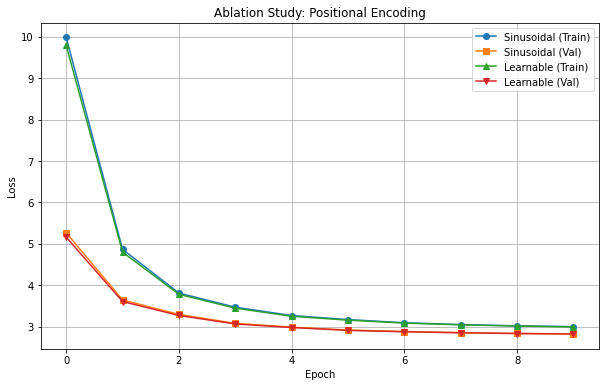


Final Evaluation Results:
Model                Train Loss   Val Loss    
---------------------------------------------
Sinusoidal           3.0009       2.8252      
Learnable            2.9945       2.8237      


In [14]:
# 绘制训练曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses_s, label="Sinusoidal (Train)", marker='o')
plt.plot(val_losses_s, label="Sinusoidal (Val)", marker='s')
plt.plot(train_losses_l, label="Learnable (Train)", marker='^')
plt.plot(val_losses_l, label="Learnable (Val)", marker='v')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Ablation Study: Positional Encoding")
plt.legend()
plt.grid(True)
plt.show()

# 评估指标表格
print("\nFinal Evaluation Results:")
print(f"{'Model':<20} {'Train Loss':<12} {'Val Loss':<12}")
print("-" * 45)
print(f"{'Sinusoidal':<20} {train_losses_s[-1]:<12.4f} {val_losses_s[-1]:<12.4f}")
print(f"{'Learnable':<20} {train_losses_l[-1]:<12.4f} {val_losses_l[-1]:<12.4f}")

In [2]:
import matplotlib.pyplot as plt

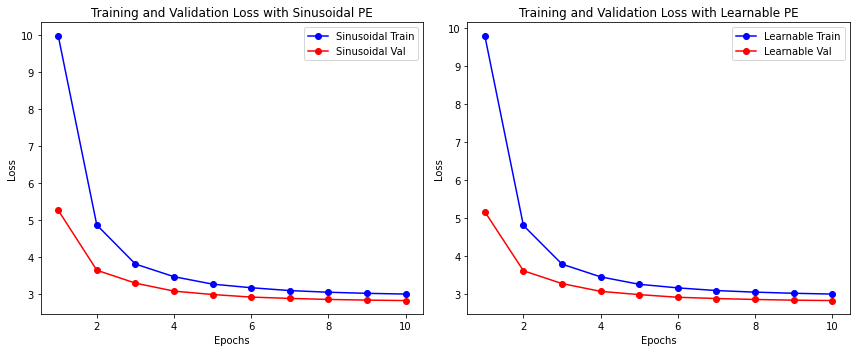

In [16]:
import matplotlib.pyplot as plt

# train_losses_s, val_losses_s 和 train_losses_l, val_losses_l 已经从两个实验中获得

def plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l):
    epochs = range(1, len(train_losses_s) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制正弦位置编码的Loss曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_s, 'bo-', label='Sinusoidal Train')
    plt.plot(epochs, val_losses_s, 'ro-', label='Sinusoidal Val')
    plt.title('Training and Validation Loss with Sinusoidal PE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制可学习位置编码的Loss曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses_l, 'bo-', label='Learnable Train')
    plt.plot(epochs, val_losses_l, 'ro-', label='Learnable Val')
    plt.title('Training and Validation Loss with Learnable PE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调用此函数来绘制Loss曲线
plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l)

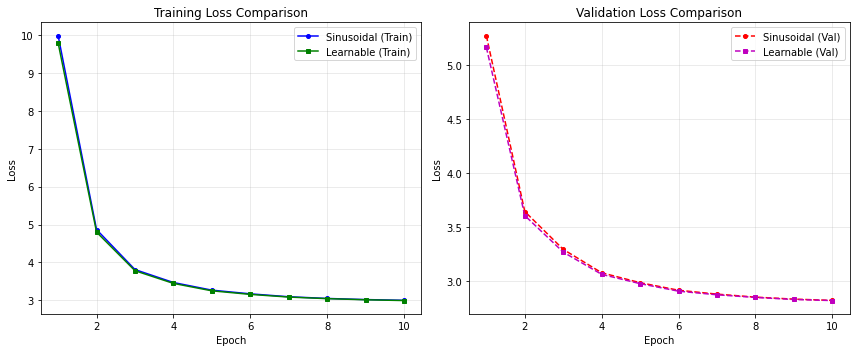

📊 Loss曲线图已保存为: loss_comparison.png


In [17]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l, save_path="loss_comparison.png"):
    epochs = range(1, len(train_losses_s) + 1)
    
    plt.figure(figsize=(12, 5))

    # 子图1：正弦 vs 可学习 - 训练Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_s, 'b-o', label='Sinusoidal (Train)', markersize=4)
    plt.plot(epochs, train_losses_l, 'g-s', label='Learnable (Train)', markersize=4)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图2：验证Loss对比
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_losses_s, 'r--o', label='Sinusoidal (Val)', markersize=4)
    plt.plot(epochs, val_losses_l, 'm--s', label='Learnable (Val)', markersize=4)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Loss曲线图已保存为: {save_path}")

# 直接调用（这些变量你已经有了！）
plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l)

In [19]:
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0, top_k=50, top_p=0.95, device='cuda'):
    model.eval()
    model.to(device)
    
    # 编码输入提示
    tokens = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=max_length - 10)
    input_ids = tokens['input_ids'].to(device)  # (1, L)
    
    # 自回归生成
    with torch.no_grad():
        for _ in range(max_length - input_ids.size(1)):
            # 前向传播，获取 logits
            logits = model(input_ids)  # (1, seq_len, vocab_size)
            logits = logits[:, -1, :] / temperature  # 只取最后一个位置，应用温度缩放
            
            # Top-K + Top-P (Nucleus) 采样
            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits = logits.masked_fill(indices_to_remove, float('-inf'))
            
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits = logits.masked_fill(indices_to_remove, float('-inf'))
            
            # 归一化并采样
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # (1, 1)
            
            # 拼接到输入序列
            input_ids = torch.cat([input_ids, next_token], dim=1)
            
            # 如果生成了 EOS，提前结束
            if next_token.item() == tokenizer.eos_token_id:
                break
    
    # 解码输出
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return generated_text

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt = "The future of artificial intelligence is"

gen1 = generate_text(model_sinusoidal, tokenizer, prompt, max_length=64, device=device)
gen2 = generate_text(model_learnable, tokenizer, prompt, max_length=64, device=device)

print("🔹 Prompt:", prompt)
print("🟢 Sinusoidal PE:", gen1)
print("🔵 Learnable PE :", gen2)

🔹 Prompt: The future of artificial intelligence is
🟢 Sinusoidal PE: The future of artificial intelligence is the , as the was the first of the city , , and 's @-@ a for the not @-@ a the on the first the a ) , and , the , and the @-@ the to the , including was was the and the time . In to the
🔵 Learnable PE : The future of artificial intelligence is the of the for the a to the for his The of the new .an is the ; : also for the two of the that ; a with the with the world . " ( in the gold , the @-@ and , were to the 1 , and – of the is :


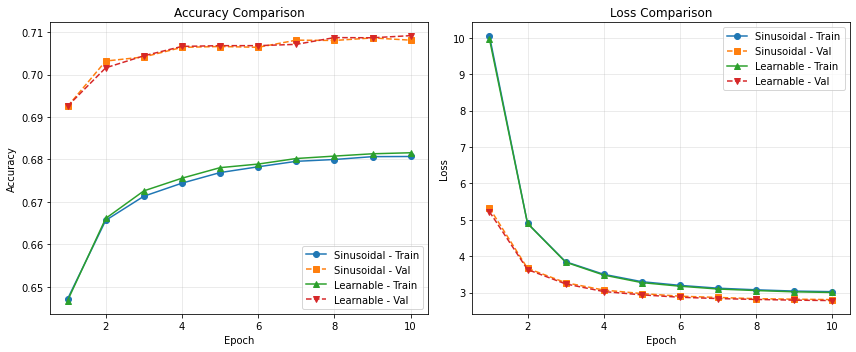

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

plt.figure(figsize=(12, 5))

# 子图1：准确率对比
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs_s, label='Sinusoidal - Train', marker='o')
plt.plot(epochs, val_accs_s, label='Sinusoidal - Val', marker='s', linestyle='--')
plt.plot(epochs, train_accs_l, label='Learnable - Train', marker='^')
plt.plot(epochs, val_accs_l, label='Learnable - Val', marker='v', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：Loss 对比（可选）
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_s, label='Sinusoidal - Train', marker='o')
plt.plot(epochs, val_losses_s, label='Sinusoidal - Val', marker='s', linestyle='--')
plt.plot(epochs, train_losses_l, label='Learnable - Train', marker='^')
plt.plot(epochs, val_losses_l, label='Learnable - Val', marker='v', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

✅ 图像已保存为 'accuracy_loss_comparison.png'


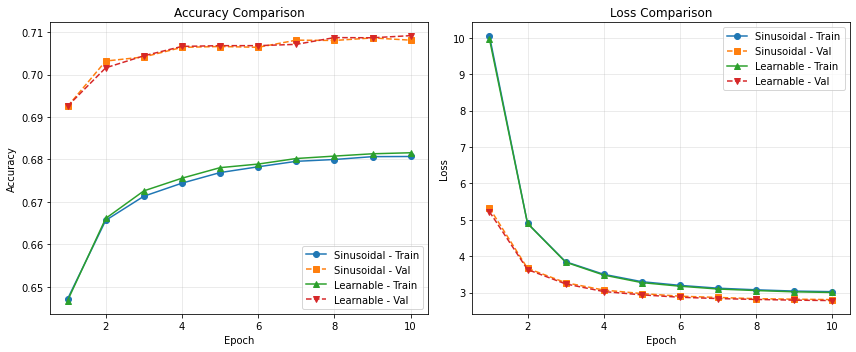

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

plt.figure(figsize=(12, 5))

# 子图1：准确率对比
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs_s, label='Sinusoidal - Train', marker='o')
plt.plot(epochs, val_accs_s, label='Sinusoidal - Val', marker='s', linestyle='--')
plt.plot(epochs, train_accs_l, label='Learnable - Train', marker='^')
plt.plot(epochs, val_accs_l, label='Learnable - Val', marker='v', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：Loss 对比
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_s, label='Sinusoidal - Train', marker='o')
plt.plot(epochs, val_losses_s, label='Sinusoidal - Val', marker='s', linestyle='--')
plt.plot(epochs, train_losses_l, label='Learnable - Train', marker='^')
plt.plot(epochs, val_losses_l, label='Learnable - Val', marker='v', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# ✅ 保存为 PNG 文件
plt.savefig("accuracy_loss_comparison.png", dpi=300, bbox_inches='tight')
print("✅ 图像已保存为 'accuracy_loss_comparison.png'")

plt.show()

✅ 图像已保存为 'loss_separate_comparison.png'


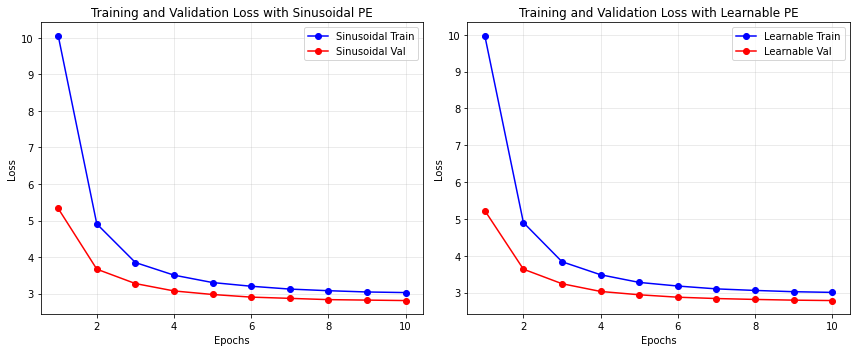

In [25]:
def plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l):
    epochs = range(1, len(train_losses_s) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制正弦位置编码的Loss曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_s, 'bo-', label='Sinusoidal Train')
    plt.plot(epochs, val_losses_s, 'ro-', label='Sinusoidal Val')
    plt.title('Training and Validation Loss with Sinusoidal PE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 绘制可学习位置编码的Loss曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses_l, 'bo-', label='Learnable Train')
    plt.plot(epochs, val_losses_l, 'ro-', label='Learnable Val')
    plt.title('Training and Validation Loss with Learnable PE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # ✅ 保存为 PNG 文件
    plt.savefig("loss_separate_comparison.png", dpi=300, bbox_inches='tight')
    print("✅ 图像已保存为 'loss_separate_comparison.png'")

    plt.show()

# 调用函数
plot_loss_curves(train_losses_s, val_losses_s, train_losses_l, val_losses_l)

📊 准确率表格：
   Epoch Sinusoidal - Train Acc Sinusoidal - Val Acc Learnable - Train Acc  \
0      1                 0.6475               0.6926                0.6471   
1      2                 0.6663               0.6979                0.6660   
2      3                 0.6728               0.7011                0.6723   
3      4                 0.6762               0.7065                0.6755   
4      5                 0.6784               0.7064                0.6781   
5      6                 0.6790               0.7054                0.6793   
6      7                 0.6800               0.7066                0.6804   
7      8                 0.6805               0.7080                0.6809   
8      9                 0.6808               0.7074                0.6813   
9     10                 0.6812               0.7084                0.6816   

  Learnable - Val Acc  
0              0.6949  
1              0.6953  
2              0.7041  
3              0.7060  
4           

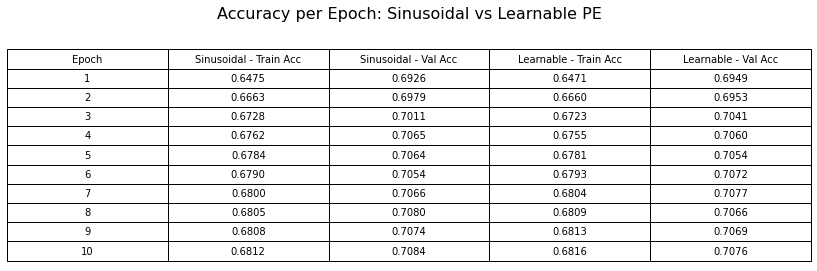

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 创建准确率数据表
epochs = list(range(1, 11))

data = {
    "Epoch": epochs,
    "Sinusoidal - Train Acc": [f"{acc:.4f}" for acc in train_accs_s],
    "Sinusoidal - Val Acc": [f"{acc:.4f}" for acc in val_accs_s],
    "Learnable - Train Acc": [f"{acc:.4f}" for acc in train_accs_l],
    "Learnable - Val Acc": [f"{acc:.4f}" for acc in val_accs_l],
}

df_acc = pd.DataFrame(data)
print("📊 准确率表格：")
print(df_acc)

# 可视化为表格图（可选）
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_acc.values,
                 colLabels=df_acc.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.6)
plt.title("Accuracy per Epoch: Sinusoidal vs Learnable PE", y=1.1, fontsize=16)
plt.savefig("accuracy_table.png", dpi=300, bbox_inches='tight')
plt.show()

In [40]:
print(f"Final Sinusoidal Val Acc: {val_accs_s[-1]:.4f}")
print(f"Final Learnable Val Acc: {val_accs_l[-1]:.4f}")

Final Sinusoidal Val Acc: 0.7084
Final Learnable Val Acc: 0.7076
